In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 1


In [2]:
def samp_to_df(samp_name, total_num):
    dfs = []
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays()
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs, ignore_index=True)
    return combine_df

In [3]:
# Set up dataframes - 2018 (recon == 1)

# Signals
GluGluToHH_df_2018 = samp_to_df('job_5_ntuple20180805v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job5ifile', 0)
VBFHH_df_2018 = samp_to_df('job_1_ntuple20180809v2/VBFHHTo2B2G_CV_1_C2V_1_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8Job1ifile', 2)

# Backgrounds
TTGJets_df_2018 = samp_to_df('job_2_ntuple20180805v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job2ifile', 19)
TTGG_0Jets_df_2018 = samp_to_df('job_3_ntuple20180805v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job3ifile', 28)
TTJets_df_2018 = samp_to_df('job_4_ntuple20180805v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job4ifile', 304)
VHToGG_df_2018 = samp_to_df('job_6_ntuple20180805v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job6ifile', 1)
ttHToGG_df_2018 = samp_to_df('job_7_ntuple20180805v1/ttHToGG_M125_TuneCP5_PSweights_13TeV-powheg-pythia8Job7ifile', 2)
VBFHToGG_df_2018 = samp_to_df('job_8_ntuple20180805v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8Job8ifile', 4)
GluGluHToGG_df_2018 = samp_to_df('job_9_ntuple20180805v1/GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8Job9ifile', 3)
GJet_SmallPt_df_2018 = samp_to_df('job_10_ntuple20180805v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job10ifile', 15)
GJet_BigPt_df_2018 = samp_to_df('job_11_ntuple20180805v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 10)
DiPhotonJetsBox2B_df_2018 = samp_to_df('job_12_ntuple20180805v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob12ifile', 2)
DiPhotonJetsBox1B_df_2018 = samp_to_df('job_13_ntuple20180805v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob13ifile', 3)
DiPhotonJetsBox_df_2018 = samp_to_df('job_14_ntuple20180805v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob14ifile', 23)
QCD_Jets_df_2018 = samp_to_df('job_2_ntuple20180809v2/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job2ifile', 78)


# Set up dataframes - 2017 (recon == 1)

# Signals
GluGluToHH_df_2017 = samp_to_df('job_8_ntuple20170805v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job8ifile', 15)
VBFHH_df_2017 = samp_to_df('job_1_ntuple20170809v2/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob1ifile', 6)

# Backgrounds
DiPhotonJetsBox1B_df_2017 = samp_to_df('job_2_ntuple20170805v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob2ifile', 15)
DiPhotonJetsBox2B_df_2017 = samp_to_df('job_3_ntuple20170805v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob3ifile', 25)
DiPhotonJetsBox_df_2017 = samp_to_df('job_4_ntuple20170805v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob4ifile', 83)
GJet_SmallPt_df_2017 = samp_to_df('job_5_ntuple20170805v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job5ifile', 11)
GJet_BigPt_df_2017 = samp_to_df('job_6_ntuple20170805v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job6ifile', 104)
GluGluHToGG_df_2017 = samp_to_df('job_7_ntuple20170805v1/GluGluHToGG_M-125_13TeV_powheg_pythia8Job7ifile', 1)
TTGG_0Jets_df_2017 = samp_to_df('job_9_ntuple20170805v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job9ifile', 8)
TTGJets_df_2017 = samp_to_df('job_10_ntuple20170805v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job10ifile', 53)
TTJets_df_2017 = samp_to_df('job_11_ntuple20170805v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job11ifile', 194)
VBFHToGG_df_2017 = samp_to_df('job_12_ntuple20170805v1/VBFHToGG_M-125_13TeV_powheg_pythia8Job12ifile', 11)
VHToGG_df_2017 = samp_to_df('job_13_ntuple20170805v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job13ifile', 0)
ttHToGG_df_2017 = samp_to_df('job_14_ntuple20170805v1/ttHToGG_M125_13TeV_powheg_pythia8Job14ifile', 3)
QCD_Jets_df_2017 = samp_to_df('job_2_ntuple20180809v2/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job2ifile', 18)


# Set up dataframes - 2016 (recon == 1)

# Signals
GluGluToHH_df_2016 = samp_to_df('job_8_ntuple20160805v1/GluGluToHHTo2B2G_node_cHHH1_TuneCUETP8M1_PSWeights_13TeV-powheg-pythia8Job8ifile', 3)
VBFHH_df_2016 = samp_to_df('job_1_ntuple20160809v2/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob1ifile', 0)

# Background
DiPhotonJetsBox1B_df_2016 = samp_to_df('job_2_ntuple20160805v1/DiPhotonJetsBox1BJet_MGG-80toInf_TuneSherpa_13TeV-SherpaJob2ifile', 17)
DiPhotonJetsBox2B_df_2016 = samp_to_df('job_3_ntuple20160805v1/DiPhotonJetsBox2BJets_MGG-80toInf_TuneSherpa_13TeV-SherpaJob3ifile', 23)
DiPhotonJetsBox_df_2016 = samp_to_df('job_4_ntuple20160805v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob4ifile', 48)
GJet_SmallPt_df_2016 = samp_to_df('job_5_ntuple20160805v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job5ifile', 13)
GJet_BigPt_df_2016 = samp_to_df('job_6_ntuple20160805v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job6ifile', 64)
GluGluHToGG_df_2016 = samp_to_df('job_7_ntuple20160805v1/GluGluHToGG_M125_13TeV_amcatnloFXFX_pythiaJob7ifile', 0)
TTGG_0Jets_df_2016 = samp_to_df('job_9_ntuple20160805v1/TTGG_0Jets_TuneCUETP8M1_13TeV_amcatnlo_madspin_pythia8Job9ifile', 2)
TTGJets_df_2016 = samp_to_df('job_10_ntuple20160805v1/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8Job10ifile', 12)
TTJets_df_2016 = samp_to_df('job_11_ntuple20160805v1/TTJets_TuneCUETP8M2T4_13TeV-amcatnloFXFX-pythia8Job11ifile', 43)
VBFHToGG_df_2016 = samp_to_df('job_12_ntuple20160805v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8_v2Job12ifile', 11)
VHToGG_df_2016 = samp_to_df('job_13_ntuple20160805v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job13ifile', 1)
ttHToGG_df_2016 = samp_to_df('job_14_ntuple20160805v1/ttHToGG_M125_13TeV_powheg_pythia8_v2Job14ifile', 0)
QCD_Jets_df_2016 = samp_to_df('job_2_ntuple20160809v2/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job2ifile', 15)


# Combine by sample (recon == 1)

# Signals 
GluGluToHH_df = pd.concat([GluGluToHH_df_2018, GluGluToHH_df_2017, GluGluToHH_df_2016], ignore_index=True)
VBFHH_df = pd.concat([VBFHH_df_2018, VBFHH_df_2017, VBFHH_df_2016], ignore_index=True)

# Backgrounds
TTGJets_df = pd.concat([TTGJets_df_2018, TTGJets_df_2017, TTGJets_df_2016], ignore_index=True)
TTGG_0Jets_df = pd.concat([TTGG_0Jets_df_2018, TTGG_0Jets_df_2017, TTGG_0Jets_df_2016], ignore_index=True)
TTJets_df = pd.concat([TTJets_df_2018, TTJets_df_2017, TTJets_df_2016], ignore_index=True)
VHToGG_df = pd.concat([VHToGG_df_2018, VHToGG_df_2017, VHToGG_df_2016], ignore_index=True)
ttHToGG_df = pd.concat([ttHToGG_df_2018, ttHToGG_df_2017, ttHToGG_df_2016], ignore_index=True)
VBFHToGG_df = pd.concat([VBFHToGG_df_2018, VBFHToGG_df_2017, VBFHToGG_df_2016], ignore_index=True)
GluGluHToGG_df = pd.concat([GluGluHToGG_df_2018, GluGluHToGG_df_2017, GluGluHToGG_df_2016], ignore_index=True)
GJet_SmallPt_df = pd.concat([GJet_SmallPt_df_2018, GJet_SmallPt_df_2017, GJet_SmallPt_df_2016], ignore_index=True)
GJet_BigPt_df = pd.concat([GJet_BigPt_df_2018, GJet_BigPt_df_2017, GJet_BigPt_df_2016], ignore_index=True)
DiPhotonJetsBox2B_df = pd.concat([DiPhotonJetsBox2B_df_2018, DiPhotonJetsBox2B_df_2017, DiPhotonJetsBox2B_df_2016], ignore_index=True)
DiPhotonJetsBox1B_df = pd.concat([DiPhotonJetsBox1B_df_2018, DiPhotonJetsBox1B_df_2017, DiPhotonJetsBox1B_df_2016], ignore_index=True)
DiPhotonJetsBox_df = pd.concat([DiPhotonJetsBox_df_2018, DiPhotonJetsBox_df_2017, DiPhotonJetsBox_df_2016], ignore_index=True)
QCD_Jets_df = pd.concat([QCD_Jets_df_2018, QCD_Jets_df_2017, QCD_Jets_df_2016], ignore_index=True)

In [4]:
training_vars = [b'leading_photon_eta', b'leading_photon_phi', 
               b'subleading_photon_eta', b'subleading_photon_phi',
                  b'leading_bjet_eta', b'leading_bjet_phi',
                  b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'leading_bjet_pt_over_dimass', b'leading_bjet_pt_over_dimass_corr'
                ]

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

In [5]:
path = '/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/'

BKD_dfs = [TTGJets_df, TTGG_0Jets_df, TTJets_df, VHToGG_df, ttHToGG_df, VBFHToGG_df, GluGluHToGG_df,
            GJet_SmallPt_df, GJet_BigPt_df, DiPhotonJetsBox2B_df, DiPhotonJetsBox1B_df, DiPhotonJetsBox_df, QCD_Jets_df]

names = ['TTG Jets', 'TTGG_0Jets', 'TTJets', 'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHToGG',
         'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox2B', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox', 'QCD_Jets']
i = 1 # select sample

sig_frame_all = GluGluToHH_df
bkg_frame_all = BKD_dfs[i]

#print(sig_frame_all.iloc[:1])

#select events with cuts
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

sig_frame = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][training_vars]
bkg_frame = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][training_vars]


sig_df = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][training_vars + w_var + aug_vars]
bkg_df = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][training_vars + w_var + aug_vars]

sig_weight = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][w_var]
bkg_weight = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][w_var]

#print(sig_frame[training_vars].head(), bkg_frame[training_vars].head())
#print(sig_frame.head(), bkg_frame.head())

In [6]:
sig_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_eta',b'subleading_bjet_phi',b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event'
0,0.918335,0.491089,0.319824,1.547607,2.209473,-2.042480,0.004900,-0.789917,0.074707,0.050354,0.125061,1.176838,0.753909,0.984135,0.000028,188.683197,123.416451,112008
1,-0.114059,2.528809,-0.079712,0.564209,-1.288086,-0.381775,-1.138916,-2.197266,0.039551,0.964844,1.004395,0.655325,0.715544,0.747966,-0.000028,111.977684,124.439453,112017
2,-0.835327,1.176514,-0.765747,2.546875,-1.357910,-1.699951,-0.727295,-0.625854,0.331299,0.424072,0.755371,0.878197,1.041834,1.011527,0.000028,111.282120,124.160385,112010
3,-0.390930,-0.474426,-0.526611,1.511963,0.323792,2.379883,2.041504,-3.094238,0.189087,0.656250,0.845337,0.802983,0.870629,0.821134,0.000028,106.316811,124.160637,112001
4,2.106934,-1.360596,1.376465,0.152924,1.395996,2.549316,1.725098,0.694458,0.998047,0.077209,1.075256,0.655613,1.426055,1.441129,0.000028,125.170486,120.000145,112006


In [7]:
bkg_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_eta',b'subleading_bjet_phi',b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event'
0,-0.310791,-0.537842,0.034973,1.554443,0.312683,-2.142578,1.145020,1.163818,0.205322,0.125000,0.330322,0.988549,0.494141,0.529404,0.000616,69.628349,134.495880,36006
1,-0.846191,-0.561401,-2.003418,1.150391,-1.380859,2.586914,-1.252686,-2.643555,0.231567,0.990234,1.221802,0.877036,1.015032,1.036644,0.000616,150.611008,169.927551,36013
2,2.106934,-0.577881,2.030762,0.263794,0.530029,0.937988,0.993530,-2.876465,0.957031,0.291016,1.248047,2.088931,0.861275,0.892128,0.000616,104.931602,101.604263,36034
3,-1.124023,0.507690,0.673096,1.693604,-1.746826,-2.346680,0.302124,-1.025146,0.806641,0.022461,0.829102,0.568063,0.552645,0.614313,0.000616,125.193336,143.473099,36044
4,0.237091,-0.073486,-1.785400,2.641113,0.485718,-2.955078,-0.677124,0.531738,0.287354,0.962402,1.249756,0.412034,0.577280,0.647920,0.000616,98.793037,116.374062,36104


In [8]:
#bkg_frame.head()
# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
#print signal, background
signal_all = sig_df.values
background_all = bkg_df.values

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
signal_all_=signal_all[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
background_all_ = background_all[randix]
#background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))
data_all = np.concatenate((signal_all_,background_all_))

sig_weight_np = sig_weight.values
bkg_weight_np = bkg_weight.values
sig_weight_np_sfl = sig_weight_np[randix2]
bkg_weight_np_sfl = bkg_weight_np[randix]
weights = np.concatenate((sig_weight_np_sfl, bkg_weight_np_sfl))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [9]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    train_weight, test_weight = weights[train_index], weights[test_index]
    x_all_test = data_all[test_index]
    #x_full_test = data_full[test_index] # full df test portion

print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

TRAIN: [     0      1      2 ... 327210 327212 327213] TEST: [     3     11     17 ... 327206 327209 327211]
TRAIN: [     0      1      2 ... 327211 327212 327213] TEST: [    15     24     26 ... 327189 327195 327204]
TRAIN: [     0      2      3 ... 327211 327212 327213] TEST: [     1      6      7 ... 327205 327207 327210]
TRAIN: [     1      3      4 ... 327209 327210 327211] TEST: [     0      2      9 ... 327203 327212 327213]
TRAIN: [     0      1      2 ... 327211 327212 327213] TEST: [     4      5     28 ... 327194 327200 327208]
(261772, 14)
(261772,)
(65442, 14)
(65442,)


In [10]:
space  = [Integer(1, 5, name='n_hidden'),
          Integer(10, 128, name='first_neuron'),
          Integer(10, 128, name = 'n_neurons'),
          Real(0.01,0.9,name='dropout_rate')]


def DNN_model(n_hidden = 1, first_neuron = 100, n_neurons = 64, dropout_rate = 0.4):
    model = Sequential()
    model.add(Dense(first_neuron, input_dim=x_train.shape[1],activation='relu'))
    model.add(Dropout(dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = 'sigmoid'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    
@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
    model_tmp = DNN_model(X['n_hidden'], X['first_neuron'], X['n_neurons'], X['dropout_rate'])
    print (model_tmp)
    model_tmp.fit(x_train, y_train, epochs = 50, verbose = 1, validation_split = 0.2,  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='Models/optimize_trial/'+names[i]+'_opt_mass_model.h5', verbose=0)])
    
    y_train_tmp = model_tmp.predict(x_train)
    predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
    train_accuracy = accuracy_score(y_train, predictions_train_tmp)
    print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))
    
    y_pred_tmp = model_tmp.predict(x_test)
    predictions_tmp = [round(value[0]) for value in y_pred_tmp]
    accuracy = accuracy_score(y_test, predictions_tmp)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    return -accuracy

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best parameters: {}".format(res_gp.x))
best_n_hidden = res_gp.x[0]
best_first_neuron = res_gp.x[1]
best_n_neurons = res_gp.x[2]
best_dropout_rate = res_gp.x[3]

New configuration: {'n_hidden': 3, 'first_neuron': 110, 'n_neurons': 111, 'dropout_rate': 0.7640540475178719}
Epoch 1/50
6545/6545 [==============================] - 14s 2ms/step - loss: 0.6094 - accuracy: 0.6727 - val_loss: 0.5689 - val_accuracy: 0.7600
Epoch 2/50
6545/6545 [==============================] - 14s 2ms/step - loss: 0.5478 - accuracy: 0.7325 - val_loss: 0.5657 - val_accuracy: 0.7192
Epoch 3/50
6545/6545 [==============================] - 14s 2ms/step - loss: 0.5383 - accuracy: 0.7372 - val_loss: 0.5906 - val_accuracy: 0.7026
Epoch 4/50
6545/6545 [==============================] - 14s 2ms/step - loss: 0.5345 - accuracy: 0.7405 - val_loss: 0.5899 - val_accuracy: 0.7014
Epoch 5/50
6545/6545 [==============================] - 14s 2ms/step - loss: 0.5312 - accuracy: 0.7417 - val_loss: 0.5619 - val_accuracy: 0.6892
Epoch 6/50
6545/6545 [==============================] - 14s 2ms/step - loss: 0.5288 - accuracy: 0.7439 - val_loss: 0.5715 - val_accuracy: 0.6947
Epoch 7/50
6545/6545

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


New configuration: {'n_hidden': 1, 'first_neuron': 128, 'n_neurons': 128, 'dropout_rate': 0.01}
Epoch 1/50
6545/6545 [==============================] - 12s 2ms/step - loss: 0.4875 - accuracy: 0.7647 - val_loss: 0.5059 - val_accuracy: 0.7617
Epoch 2/50
6545/6545 [==============================] - 12s 2ms/step - loss: 0.4368 - accuracy: 0.7977 - val_loss: 0.5026 - val_accuracy: 0.7575
Epoch 3/50
6545/6545 [==============================] - 12s 2ms/step - loss: 0.4140 - accuracy: 0.8120 - val_loss: 0.5465 - val_accuracy: 0.7394
Epoch 4/50
6545/6545 [==============================] - 12s 2ms/step - loss: 0.4031 - accuracy: 0.8192 - val_loss: 0.4854 - val_accuracy: 0.7705
Epoch 5/50
6545/6545 [==============================] - 12s 2ms/step - loss: 0.3952 - accuracy: 0.8231 - val_loss: 0.4218 - val_accuracy: 0.8068
Epoch 6/50
6545/6545 [==============================] - 12s 2ms/step - loss: 0.3893 - accuracy: 0.8260 - val_loss: 0.4456 - val_accuracy: 0.7978
Epoch 7/50
6545/6545 [============

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


New configuration: {'n_hidden': 5, 'first_neuron': 128, 'n_neurons': 10, 'dropout_rate': 0.01}
Epoch 1/50
6545/6545 [==============================] - 16s 2ms/step - loss: 0.5115 - accuracy: 0.7491 - val_loss: 0.4864 - val_accuracy: 0.7724
Epoch 2/50
6545/6545 [==============================] - 16s 2ms/step - loss: 0.4545 - accuracy: 0.7881 - val_loss: 0.4595 - val_accuracy: 0.7922
Epoch 3/50
6545/6545 [==============================] - 15s 2ms/step - loss: 0.4328 - accuracy: 0.8013 - val_loss: 0.4803 - val_accuracy: 0.7775
Epoch 4/50
6545/6545 [==============================] - 15s 2ms/step - loss: 0.4210 - accuracy: 0.8092 - val_loss: 0.5039 - val_accuracy: 0.7552
Epoch 5/50
6545/6545 [==============================] - 16s 2ms/step - loss: 0.4133 - accuracy: 0.8133 - val_loss: 0.4289 - val_accuracy: 0.8012
Epoch 6/50
6545/6545 [==============================] - 16s 2ms/step - loss: 0.4074 - accuracy: 0.8163 - val_loss: 0.4281 - val_accuracy: 0.8053
Epoch 7/50
6545/6545 [=============

2021-08-17 12:04:48.291212: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-08-17 12:04:48.366517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-08-17 12:04:48.366547: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-08-17 12:04:48.368286: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-08-17 12:04:48.369622: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-08-17 12:04:48.370112: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuran

In [11]:
model = DNN_model(best_n_hidden, best_first_neuron, best_n_neurons, best_dropout_rate)

#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='Models/optimize_trial/'+names[i]+'_opt_mass_model.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.5125 - accuracy: 0.7469 - val_loss: 0.4778 - val_accuracy: 0.7783
Epoch 2/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.4630 - accuracy: 0.7815 - val_loss: 0.5550 - val_accuracy: 0.7276
Epoch 3/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.4367 - accuracy: 0.7973 - val_loss: 0.5411 - val_accuracy: 0.7409
Epoch 4/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.4193 - accuracy: 0.8091 - val_loss: 0.4920 - val_accuracy: 0.7795
Epoch 5/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.4105 - accuracy: 0.8130 - val_loss: 0.4904 - val_accuracy: 0.7782
Epoch 6/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.4053 - accuracy: 0.8168 - val_loss: 0.4132 - val_accuracy: 0.8135
Epoch 7/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.4006 - accuracy: 0.8197 - val_loss: 0.4270 - val_accuracy:

In [12]:
# Accuracy

y_train_tmp = model.predict(x_train)
predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
train_accuracy = accuracy_score(y_train, predictions_train_tmp)
print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))

y_pred_tmp = model.predict(x_test)
predictions_tmp = [round(value[0]) for value in y_pred_tmp]
accuracy = accuracy_score(y_test, predictions_tmp)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Training Accuracy: 82.78%
Accuracy: 82.38%


In [13]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

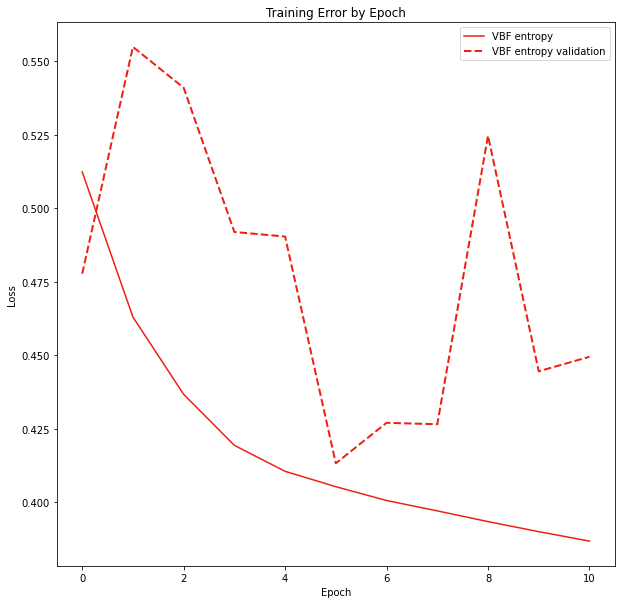

In [14]:
show_losses( [("VBF entropy", hist)])

In [15]:
y_pred2 = model.predict(x_test)
y_pred = y_pred2.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

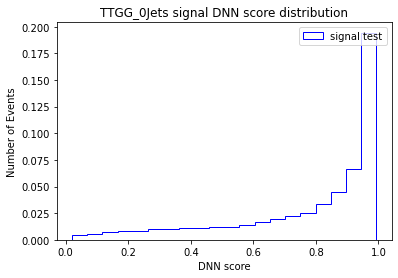

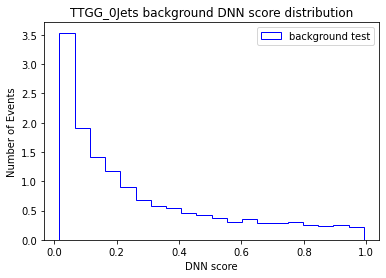

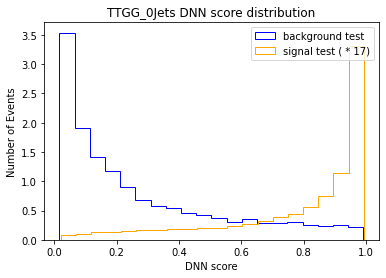

In [18]:
# Plot DNN score distribution

bgd = y_pred[y_test == 0]
sgl = y_pred[y_test == 1]
sgl_weight = test_weight[y_test == 1].flatten()
bgd_weight = test_weight[y_test == 0].flatten()

plt.hist(sgl, color='blue', weights= sgl_weight, histtype='step', bins = 20, label= 'signal test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.55, ymin=0, ymax = 0.10, color = 'orange')
plt.legend(loc = 'best')
plt.title(names[i] + ' signal DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/optimize_trial/{names[i]}_opt_xpt_sig_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.5, ymin=0, ymax = 10, color = 'orange')
plt.legend(loc = 'best')
plt.title(names[i] + ' background DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/optimize_trial/{names[i]}_opt_xpt_bkg_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.hist(sgl, color='orange', weights= 17 * sgl_weight, histtype='step', bins = 20, label= 'signal test ( * 17)')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title(names[i] + ' DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/optimize_trial/{names[i]}_opt_xpt_score.png', format='png')
plt.show()

In [19]:
bgd_x_all = x_all_test[y_test == 0]
bgd_y = y_pred[y_test == 0]
bgd_test = y_test[y_test == 0]
print(bgd_x_all.shape)
print(bgd_y.shape)

sig_x_all = x_all_test[y_test == 1]
sig_y = y_pred[y_test == 1]
sig_test = y_test[y_test == 1]

result_sig_df = pd.DataFrame(sig_x_all, columns = list(sig_df.columns))
result_sig_df[b'DNN score'] = sig_y
result_bgd_df = pd.DataFrame(bgd_x_all, columns = list(bkg_df.columns))
result_bgd_df[b'DNN score'] = bgd_y

(36722, 18)
(36722,)


In [20]:
result_sig_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_eta',b'subleading_bjet_phi',b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'DNN score'
0,-0.323303,-2.483887,0.663574,2.422363,-0.774536,-0.156189,-1.095459,1.529297,0.648926,0.999512,1.648438,0.667300,0.827446,0.844312,0.000016,112.318489,125.684120,183317.0,0.971172
1,0.927612,0.502075,-0.409546,1.832764,1.804443,-2.771973,1.323975,-2.543945,0.302734,0.051880,0.354614,0.545251,2.441639,0.658416,0.000016,35.938972,126.671967,117919.0,0.205077
2,-1.000000,-1.349609,-0.710449,-0.079605,-1.273926,1.572021,-1.493652,2.712402,0.700195,0.078064,0.778259,1.830829,1.081523,1.090857,0.000016,125.979713,123.638374,152760.0,0.939915
3,0.301819,-0.052704,0.822632,0.882324,0.208344,3.086426,0.479797,-2.487305,0.645020,0.320068,0.965088,1.431902,1.437534,1.541538,0.000016,104.606224,122.683662,101454.0,0.977689
4,-1.119141,1.115723,-0.720825,2.534180,0.350220,-0.685303,0.298645,-0.084793,0.995605,0.193115,1.188721,1.194462,1.752833,0.865119,0.000019,44.891609,125.958427,78139.0,0.439502


In [21]:
result_bgd_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_eta',b'subleading_bjet_phi',b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'DNN score'
0,2.086426,-1.916504,0.986206,-1.494629,2.315430,1.620361,-0.769531,-2.275391,0.766113,0.928711,1.694824,1.561841,0.536581,1.340489,0.000616,324.275421,143.895096,1399189.0,0.357113
1,-1.773926,2.079102,0.162994,2.702637,-2.225586,-0.293640,-1.626221,1.484619,0.255859,-2.000000,-1.744141,0.461026,1.264409,1.242804,0.000616,104.495422,103.300468,956202.0,0.201859
2,-0.764404,-1.356201,-1.639648,-0.874146,-1.739014,2.846191,0.417786,0.802612,0.685059,0.957031,1.642090,1.772837,0.379647,0.687917,0.000610,218.130402,139.044937,438637.0,0.208009
3,0.535767,1.606689,-0.610107,0.760132,-0.169220,-1.945312,-1.162354,-0.453857,0.046448,0.968750,1.015198,1.392044,1.171290,1.276425,-0.000853,163.921814,168.865112,380745.0,0.934385
4,-0.806396,-2.348145,0.632812,-0.663696,-0.385254,0.085724,0.436768,-2.334473,0.690918,0.985352,1.676270,0.839714,0.592535,0.387155,0.000616,70.354485,107.023170,1334468.0,0.067992


In [22]:
# Bkg reduction
# Bkg reduction
def significance_file(k):
    file.write(f'cutoff: {k}\n')
    bgd = y_pred[y_test == 0]
    file.write(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    file.write(f'# false signal: {sum(bgd_bin)}\n')

    sgl = y_pred[y_test == 1]
    file.write(f'# signal: {len(sgl)}\n')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    file.write(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten()
    bgd_weight = test_weight[y_test == 0].flatten()
    file.write(f'original background: {np.sum(bkg_weight_np_sfl)}\n')
    file.write(f'original test background: {np.sum(bgd_weight)}\n')
    file.write(f'original signal: {np.sum(sig_weight_np_sfl)}\n')
    file.write(f'original test signal: {np.sum(sgl_weight)}\n')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    file.write(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    file.write(f'remaining signal: {re_sig}\n')
    file.write(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    file.write(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    file.write(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    file.write('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

def significance_print(k):
    print(f'cutoff: {k}')
    bgd = y_pred[y_test == 0]
    print(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    print(f'# false signal: {sum(bgd_bin)}\n')

    bgd = y_pred[y_test == 0]
    print(f'# signal: {len(sgl)}')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    print(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten()
    bgd_weight = test_weight[y_test == 0].flatten()
    print(f'original background: {np.sum(bkg_weight_np_sfl)}')
    print(f'original test background: {np.sum(bgd_weight)}')
    print(f'original signal: {np.sum(sig_weight_np_sfl)}')
    print(f'original test signal: {np.sum(sgl_weight)}')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    print(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    print(f'remaining signal: {re_sig}\n')
    print(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    print(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    print(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    print('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

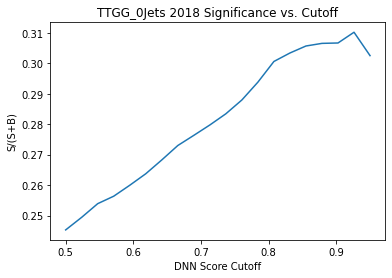

In [23]:
test_sc = np.linspace(0.5, 0.95, 20)
sc_vals = []
file = open('DNN_Score_Nums/optimize_trial/' + names[i]+'_opt_xpt_DNN_score.txt', "w")
for value in test_sc:
    sc_vals.append(significance_file(value))

file.close()
    
plt.plot(test_sc, sc_vals, label = names[i])
plt.xlabel('DNN Score Cutoff')
plt.ylabel('S/(S+B)')
plt.title(names[i] + ' 2018 Significance vs. Cutoff')
plt.savefig(fname = f'DNN_Score_Plts/optimize_trial/{names[i]}_opt_xpt_significance', format='png')
plt.show()

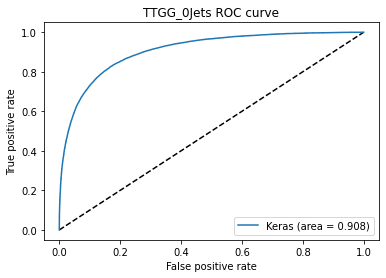

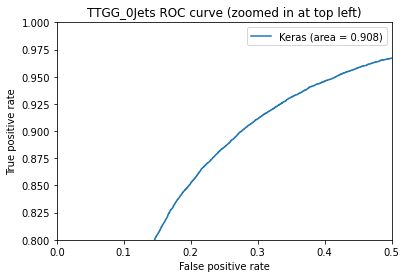

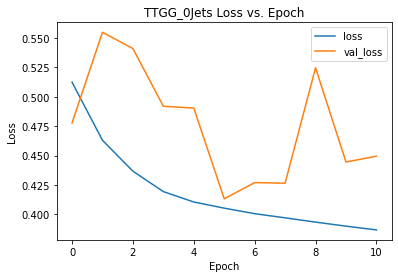

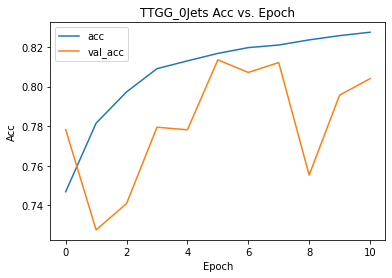

In [24]:
# Plots

# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(names[i] + ' ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/optimize_trial/{names[i]}_opt_xpt_ROC_curve.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= 'Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(names[i] + ' ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/optimize_trial/{names[i]}_opt_xpt_ROC_curve_zoom')
plt.show()


# plot loss vs epoch
plt.figure(3)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(names[i] + ' Loss vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/optimize_trial/{names[i]}_opt_xpt_loss_epoch.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title(names[i] + ' Acc vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/optimize_trial/{names[i]}_opt_xpt_acc_epoch.png', format='png')
plt.show()

In [25]:
file = open('Efficiency/optimize_trial/' + names[i]+'_opt_mass_DNN_efficiency.txt', "w")
file.write('1% acceptance\n')
for x in tpr_keras[fpr_keras>=0.009997]:
    if x in tpr_keras[fpr_keras<=0.01]:
        file.write(f'{x}\n')

file.write('\n')

file.write('0.1% acceptance\n')
for y in tpr_keras[fpr_keras>=0.0009997]:
    if y in tpr_keras[fpr_keras<=0.001]:
        file.write(f'{y}\n')
file.close()

In [26]:
def check_mass_gg(label, test_all, var_index, weight_index, dnn_index, label_index, samp):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title(names[samp]+' '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/optimize_trial/{names[samp]}_opt_xpt_gg_mass_sculpt_{samples[label]}')
    
def check_mass_jj(label, test_all, var_index, weight_index, dnn_index, label_index, samp):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{jj}$',fontsize=fontsize)
    plt.title(names[samp]+' '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/optimize_trial/{names[samp]}_opt_xpt_jj_mass_sculpt_{samples[label]}')

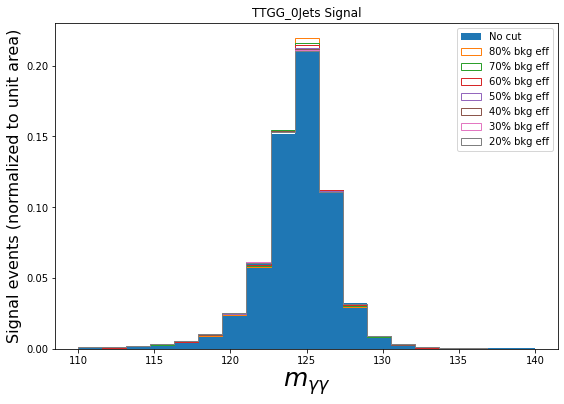

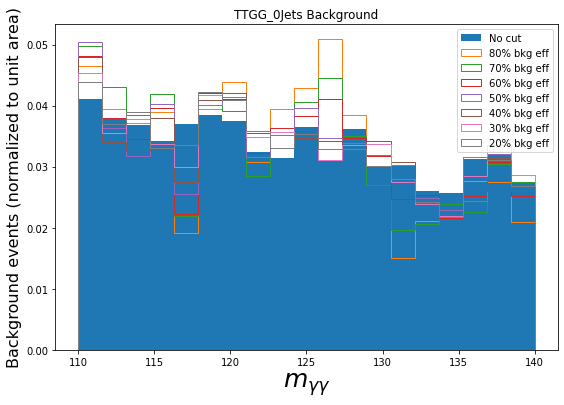

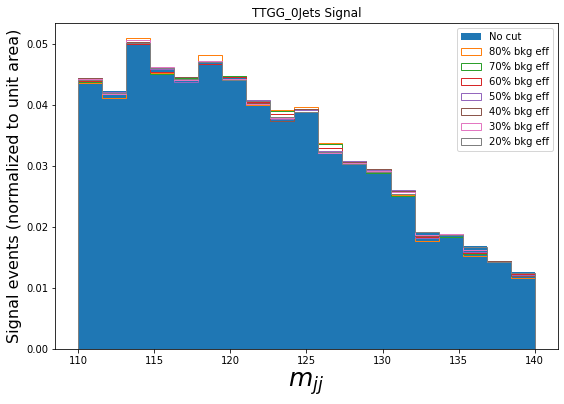

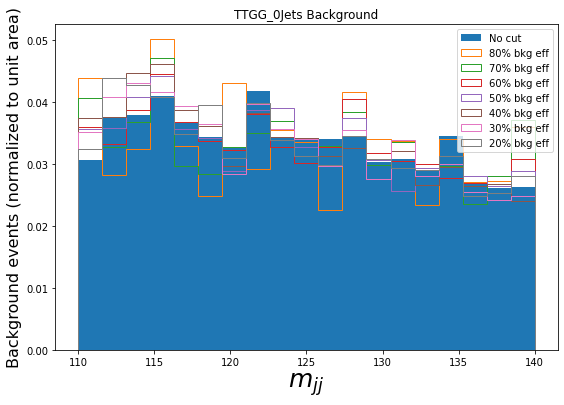

In [27]:
label_test = np.array([y_test]).T
test_all = np.concatenate((x_all_test,y_pred2, label_test), 1)
#signal
check_mass_gg(1, test_all, 16, 14, 18, 19, i)
#bkg
check_mass_gg(0, test_all, 16, 14, 18, 19, i)

#signal
check_mass_jj(1, test_all, 15, 14, 18, 19, i)
#bkg
check_mass_jj(0, test_all, 15, 14, 18, 19, i)

In [28]:
#for hlf in training_vars:
    #plt.figure()
    #plt.hist(sig_df[hlf], bins=40, density=True, weights=sig_df[b'genweight'],
             #histtype='step', label='signal')
    #plt.hist(bkg_df[hlf], bins=40, density=True, weights=bkg_df[b'genweight'], 
             #histtype='step', label= names[i] + ' background')
    #plt.xlabel(hlf)
    #plt.savefig(fname = f'BackgroundVsSignal_Plts/optimize_trial/{names[i]}_{hlf}')
    #plt.legend(loc='best')

# 